In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy.io as io
import numpy as np
import collections
from networkx.algorithms.community import modularity
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

Initialization of the network.

In [ ]:
matrix = io.mmread('network/steam_friends_network.mtx')

G = nx.from_scipy_sparse_array(matrix)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print("First 10 edges:", list(G.edges())[:10])

Nodes: 1224, Edges: 2081
First 10 edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 18)]


Gather some insights into the description of the network.

In [ ]:
def describe_network(G, name):
    # Basic statistics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Check if graph is directed
    is_directed = G.is_directed()

    # Check if graph is weighted
    is_weighted = any(data.get('weight', 1) != 1 for _, _, data in G.edges(data=True))

    # Density
    density = nx.density(G)

    print(f"\nNetwork Description for {name}:")
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Directed: {is_directed}")
    print(f"Weighted: {is_weighted}")
    print(f"Network density: {density:.6f}\n")
    return num_nodes, num_edges, is_directed, is_weighted, density

    
num_nodes, num_edges, is_directed, is_weighted, density = describe_network(G, "Steam Network")


Network Description for Original Network:
Number of nodes: 1224
Number of edges: 2081
Directed: False
Weighted: False
Network density: 0.002780



Steam Network
* Nature of the Network:
    * Undirected & Unweighted: Each edge represents a mutual friendship between two individuals.
    * Gaming Social Network: Nodes correspond to individual Steam accounts, and edges indicate established friendships within the platform.
* Significance and Meaning:
    * Real-World Representation: Captures genuine social bonds in the gaming community, reflecting how players form friendships around shared interests and games.
    * Community Structure & Clustering: Despite a low overall density (0.00278), the Steam friends network exhibits pronounced modularity—users naturally form tightly knit clusters around shared games or interests. These locally dense pockets foster efficient information flow, strong peer support, and high resilience within each gaming community.
    * Research Value: Analyzing the Steam friends network can shed light on how game recommendations propagate, how peer influence shapes play patterns, and how resilient the gaming community is to churn or platform changes.


### Utility code.

In [9]:
def degree_summary_and_distribution(G: nx.Graph):
    # Degree of a Node: The number of edges connected to a node.
    # Interpretation: A node's degree represents how many friends a person has on facebook.

    #  - the lowest number of friends
    #  - the highest number of friends
    #  - the average number of friends
    degrees = [d for _, d in G.degree()]
    min_degree = np.min(degrees)
    max_degree = np.max(degrees)
    avg_degree = np.mean(degrees)

    print(f"Min Degree: {min_degree}")
    print(f"Max Degree: {max_degree}")
    print(f"Average Degree: {avg_degree}")

    # count how many times each degree appears
    degree_count = collections.Counter(degrees)
    # sort the info and have separate lists
    degree_values, node_counts = zip(*sorted(degree_count.items()))

    total = sum(node_counts)
    node_counts = [y / total for y in node_counts]

    # plot as a dot graph
    plt.figure(figsize=(7, 5))
    plt.scatter(degree_values, node_counts, alpha=0.6, edgecolors='k')
    plt.title("Degree Distribution (Dot Plot)")
    plt.xlabel("Degree")
    plt.ylabel("Number of Nodes")
    plt.grid(True)
    plt.show()


def connectivity(G: nx.Graph):
    is_connected = nx.is_connected(G)
    if not is_connected:
        # Connected Component: A group of nodes that are connected by paths.
        # The connected components can indicate if the network is one big cluster or composed of small ones.
        # Interpretation: Groups of friends isolated or interconnected.
        connected_components = list(nx.connected_components(G))
        num_connected_components = len(connected_components)
        largest_component_size = max(len(c) for c in connected_components)
        largest_cc = G.subgraph(max(connected_components, key=len))

    else:
        largest_component_size = len(G)
        largest_cc = G
        num_connected_components = 1

    print(f"The graph is connected: {is_connected}.")
    print(f"Number of Connected Components: {num_connected_components}.")
    print(f"Largest Component Size: {largest_component_size}.")

    # Diameter: the largest distance between any pair of nodes in the network.
    # Interpretation: the longest "friendship chain" connecting two users.
    diameter = nx.diameter(largest_cc) if nx.is_connected(largest_cc) else None
    
    print(f"Diameter: {diameter}")


def clustering_coefficient_and_degree_distribution_plot(G: nx.Graph):
    # Clustering Coefficient: Measures how tightly connected a node’s neighbors are (how likely it is for 2 nodes with a common neighbor to be linked).
    # Interpretation: How interconnected are on average the users. High clustering means high interaction between the friends of an user.
    avg_clustering = nx.average_clustering(G)
    
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Edge density: fraction of actual edges compared to the maximum possible edges.
    # Used to determine if the clustering coefficient is high or not.
    # NOTE: A low density means the network is sparse.
    edge_density = nx.density(G)

    print(f"Edge Density: {edge_density}")
    print(f"Clustering Coefficient is {"high" if avg_clustering > edge_density else "low"} compared to the edge density.")

    # plot clustering coefficient probability per degree
    degree_per_node = dict(G.degree())
    clustering_per_node = nx.clustering(G)

    # group clustering coefficients by degree
    clustering_by_degree = {}
    for node in G.nodes():
        k = degree_per_node[node]
        c = clustering_per_node[node]
        # if key already exists, make no change, else give a default
        clustering_by_degree.setdefault(k, [])
        clustering_by_degree[k].append(c)

    # compute average clustering coefficient per degree
    sorted_degrees = sorted(clustering_by_degree)
    avg_clustering_values_per_degree = [np.mean(clustering_by_degree[degree]) for degree in sorted_degrees]

    # Plot in log-log scale
    plt.figure(figsize=(6, 5))
    plt.scatter(sorted_degrees, avg_clustering_values_per_degree, alpha=0.6, edgecolors='k')
    plt.xlabel('Degree $k$')
    plt.ylabel('Clustering Coefficient $C(k)$')
    plt.title('Clustering Coefficient vs Degree')
    plt.grid(True)
    plt.show()
    
    return avg_clustering


def betweenness_centrality_distribution(G: nx.Graph):
    # Betweenness Centrality: measures how often a node appears on shortest paths between other nodes.
    # Interpretation: People with high betweeness are the connection between two separate groups. They transfer information between the groups.
    
    betweenness = list(nx.betweenness_centrality(G).values())

    avg_betweenness = np.mean(betweenness)
    max_betweenness = np.max(betweenness)

    print(f"Average Betweenness Centrality: {avg_betweenness}")
    print(f"Max Betweenness Centrality: {max_betweenness}")

    # Plot distribution
    plt.figure()
    plt.hist(betweenness, bins="auto", edgecolor="black", linewidth=0.2)
    plt.title("Betweenness Centrality Distribution")
    plt.xlabel("Betweenness Centrality")
    plt.ylabel("Frequency")
    # to diminish the big spikes in the plot 
    plt.yscale("log")
    plt.show()


def shortest_path_length_and_plot(largest_cc: nx.Graph):
    # Shortest path: minimum number of edges required to travel from one node to another.
    # Interpretation: The degree of separation between two users measured in friendships. 
    # NOTE: compare with no. nodes? 
    
    avg_shortest_path_length = nx.average_shortest_path_length(largest_cc)
    diameter = nx.diameter(largest_cc)

    print(f"Average Shortest Path Length: {avg_shortest_path_length}")
    print(f" - Diameter: {diameter}")

    # compute shortest paths between all node pairs
    lengths = dict(nx.all_pairs_shortest_path_length(largest_cc))

    # flatten distances into a list
    distance_counts = {}
    for source in lengths:
        for target in lengths[source]:
            if source != target:  # exclude self-loops
                d = lengths[source][target]
                distance_counts[d] = distance_counts.get(d, 0) + 1

    # normalize to get probability distribution
    total_pairs = sum(distance_counts.values())
    d_vals = sorted(distance_counts.keys())
    p_vals = [distance_counts[d] / total_pairs for d in d_vals]

    # plot probability distribution
    plt.figure(figsize=(7, 5))
    plt.plot(d_vals, p_vals, marker='o', alpha=0.6)
    plt.title("Shortest Path Length Distribution")
    plt.xlabel("Shortest Path Length $d$")
    plt.ylabel("Probability $p_d$")
    plt.axvline(x=np.average(d_vals, weights=p_vals), linestyle='--', color='gray', label='Average ⟨d⟩')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
def compute_and_display_degree_centrality(G, graph_name):
    """
    Compute and display the top 5 nodes by degree centrality.
    :param G: NetworkX graph
    :param graph_name: Name to label the output
    """
    print(f"\n=== {graph_name} ===")

    degree_centrality = nx.degree_centrality(G)
    
    dc_sorted = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

    print("Top 5 nodes by Degree Centrality:")
    for i in range(5):
        node, centrality = dc_sorted[i]
        print(f"Node {node}: {centrality:.4f}")


def compute_and_display_betweenness_centrality(G, graph_name):
    """
    Betweenness centrality measures how often a node lies on the shortest paths between others.
    High values indicate nodes that act as bridges in the network.
    """
    print(f"\n=== {graph_name} ===")

    betweenness = nx.betweenness_centrality(G)
    bc_sorted = sorted(betweenness.items(), key=lambda item: item[1], reverse=True)

    print("Top 5 nodes by Betweenness Centrality:")
    for i in range(5):
        node, centrality = bc_sorted[i]
        print(f"Node {node}: {centrality:.4f}")

    return betweenness  

     

def compute_and_display_closeness_centrality(G, graph_name):
    """
    Closeness centrality shows how close a node is to all other nodes in the network.
    A high value means the node can quickly interact with others.
    """
    print(f"\n=== {graph_name} ===")

    closeness = nx.closeness_centrality(G)
    cc_sorted = sorted(closeness.items(), key=lambda item: item[1], reverse=True)

    print("Top 5 nodes by Closeness Centrality:")
    for i in range(5):
        node, centrality = cc_sorted[i]
        print(f"Node {node}: {centrality:.4f}")

    return closeness  
    
     

def compute_and_display_eigenvector_centrality(G, graph_name):
    """
    Eigenvector centrality reflects both the quantity and quality of a node’s connections.
    Nodes connected to other high-scoring nodes receive higher scores.
    """
    print(f"\n=== {graph_name} ===")
    
    try:
        eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
        ev_sorted = sorted(eigenvector.items(), key=lambda item: item[1], reverse=True)

        print("Top 5 nodes by Eigenvector Centrality:")
        for i in range(5):
            node, centrality = ev_sorted[i]
            print(f"Node {node}: {centrality:.4f}")


        return eigenvector 

         
    except nx.NetworkXError as e:
        print(f"⚠️ Could not compute eigenvector centrality for {graph_name}: {e}")
        return None

def plot_vs_degree(G, data, title, x_label, y_label):
    degree = nx.degree_centrality(G)

    x = [data[node] for node in G.nodes()]
    y = [degree[node] for node in G.nodes()]

    plt.figure(figsize=(7, 5))
    plt.scatter(x, y, alpha=0.6, edgecolors='k')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [11]:
def get_community_colors(G):
    communities = list(nx_comm.greedy_modularity_communities(G))
    color_map = {}
    for i, community in enumerate(communities):
        for node in community:
            color_map[node] = i
    return [color_map[node] for node in G.nodes()]

def plot_graph(G, name, layout_type="spring", figsize=(20, 20), opacity=0.8, wdth=0.3):
    colors = get_community_colors(G)

    layout_funcs = {
        "spring": nx.spring_layout,
        "kamada_kawai": nx.kamada_kawai_layout,
        "spectral": nx.spectral_layout,
        "shell": nx.shell_layout,
        "random": nx.random_layout,
        "fruchterman_reingold": nx.fruchterman_reingold_layout
    }
    
    pos = layout_funcs.get(layout_type, nx.spring_layout)(G)

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.get_cmap("tab10"), node_size=30, alpha=0.9)
    nx.draw_networkx_edges(G, pos, edge_color="black", width=wdth, alpha=opacity)
    plt.title(f"{name} - {layout_type.capitalize()} Layout", fontsize=32)
    plt.axis('off')
    plt.show()

def plot_graph_all_layouts(G, name, figsize=(30, 20)):
    colors = get_community_colors(G)

    layout_funcs = {
        "spring": nx.spring_layout,
        "kamada_kawai": nx.kamada_kawai_layout,
        "spectral": nx.spectral_layout,
        "shell": nx.shell_layout,
        "random": nx.random_layout,
        "fruchterman_reingold": nx.fruchterman_reingold_layout
    }

    num_layouts = len(layout_funcs)
    cols = 3
    rows = (num_layouts + cols - 1) // cols

    plt.figure(figsize=figsize)
    
    for i, (layout_name, layout_func) in enumerate(layout_funcs.items(), 1):
        pos = layout_func(G)

        plt.subplot(rows, cols, i)
        nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.get_cmap("tab10"), node_size=20, alpha=0.9)
        nx.draw_networkx_edges(G, pos, edge_color="black", width=0.3, alpha=0.3)
        plt.title(f"{layout_name.capitalize()} Layout", fontsize=24)
        plt.axis('off')

    plt.suptitle(f"{name} - All Layouts", fontsize=36)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Steam Network (**name**)

#### Connectivity

#### Degree Distribution

Min Degree: 1
Max Degree: 54
Average Degree: 3.400326797385621


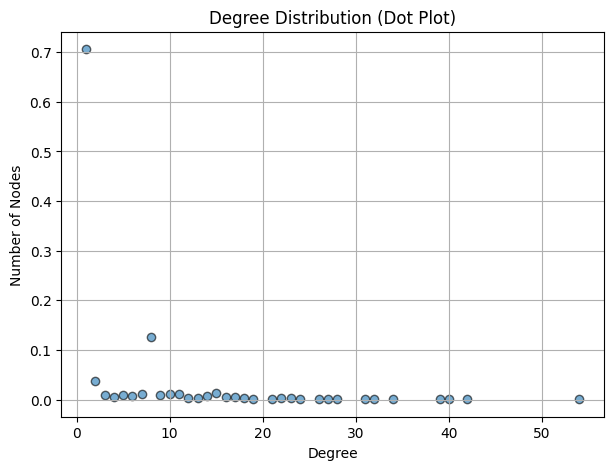

In [14]:
degree_summary_and_distribution(G)

The plot shows that most players only have a handful of friends—think one to five connections, while a few others have 30, 40 or even 50-plus friendships. 
- **Heavy-tailed**: most CS players have only 1–5 friends, but a few hubs reach 30–50+.
- **Scale-free-like structure**: hubs co-exist with many low-degree nodes.

#### Betweeness Centrality Distribution

Average Betweenness Centrality: 0.0039317219376461465
Max Betweenness Centrality: 0.2956441245420267


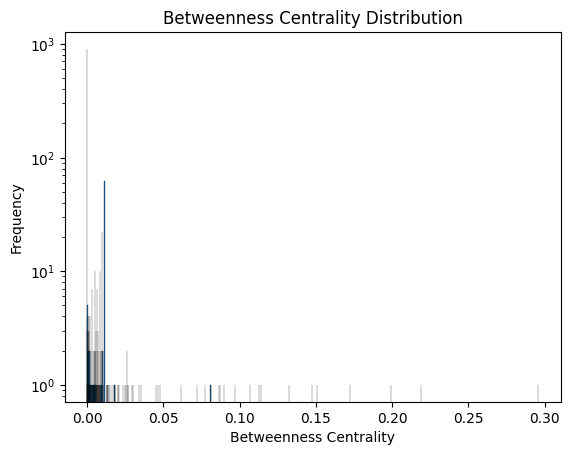

In [15]:
betweenness_centrality_distribution(G)

Very few nodes are hubs which connect other nodes (their betweenness is near zero), but there’s a tiny group whose betweenness is up to around 0.3. Those are key connectors—the players who really keep the whole community linked together.

#### Clustering Coefficient

Average Clustering Coefficient: 0.06681918173095623
Edge Density: 0.002780316269325937
Clustering Coefficient is high compared to the edge density.


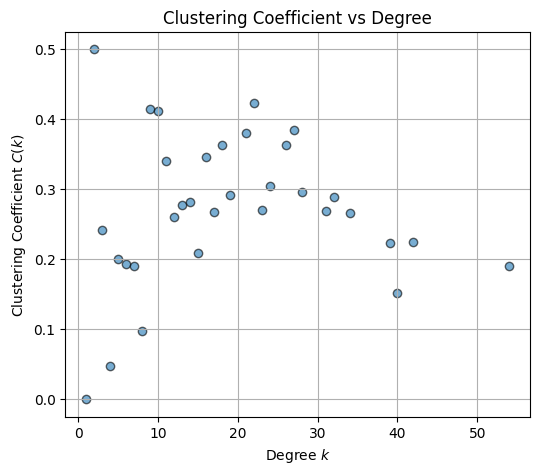

0.06681918173095623

In [16]:
clustering_coefficient_and_degree_distribution_plot(G)

Here is seen that low-degree players tend to form tight little cliques (their clustering coefficients hover around 0.3–0.5), whereas the big hubs—those with 20 or more friends—have clustering down around 0.15–0.25. That pattern says your network is built from small, closely knit friendship circles that are themselves stitched together by a few high-degree players.

#### Average Shortest Path

Average Shortest Path Length: 3.763694572367461
 - Diameter: 4


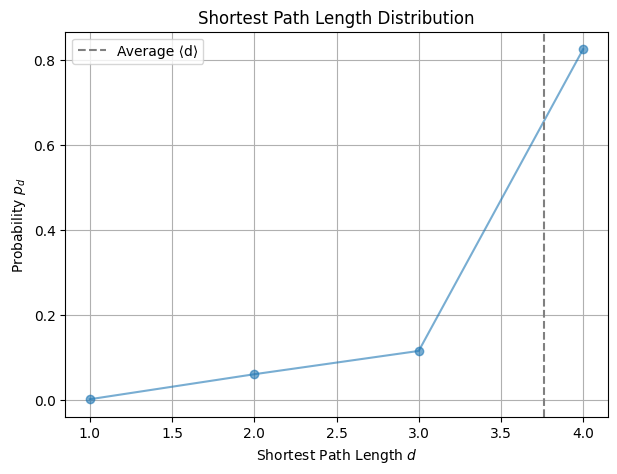

In [ ]:
# get the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(largest_cc).copy()

shortest_path_length_and_plot(subgraph)

It’s a classic “small-world” graph—despite being sparse overall, everyone is connected through just a few intermediaries. Even though most friendships form tight local clusters, you never need more than four introductions to link any two players.

#### Visualization

#### Important Nodes

**Degree Centrality**

In [27]:
compute_and_display_degree_centrality(G, "Real Network")



=== Real Network ===
Top 5 nodes by Degree Centrality:
Node 7: 0.0442
Node 1: 0.0343
Node 5: 0.0327
Node 11: 0.0319
Node 8: 0.0278


**Betweeness Centrality**


=== Real Network ===
Top 5 nodes by Betweenness Centrality:
Node 4: 0.2956
Node 1: 0.2188
Node 2: 0.1995
Node 5: 0.1721
Node 39: 0.1508


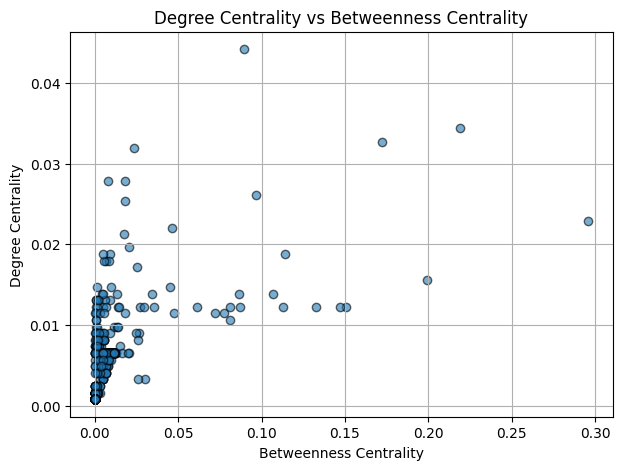

In [28]:
bc = compute_and_display_betweenness_centrality(G, "Real Network")
plot_vs_degree(G, bc, "Degree Centrality vs Betweenness Centrality", "Betweenness Centrality", "Degree Centrality")

- Most nodes exhibit low values for both metrics, forming a dense cluster near the origin.

- A few nodes stand out with relatively high betweenness and moderate-to-high degree centrality.

- The outliers with high betweenness centrality likely act as critical intermediaries or bottlenecks, even if they're not the most connected.

__Interpretation__: These results suggest that node influence in the network is driven more by structural position than direct connectivity, highlighting the role of strategic intermediaries over simple hubs.

**Closeness Centrality**


=== Real Network ===
Top 5 nodes by Closeness Centrality:
Node 1: 0.2987
Node 6: 0.2896
Node 4: 0.2883
Node 0: 0.2840
Node 2: 0.2797


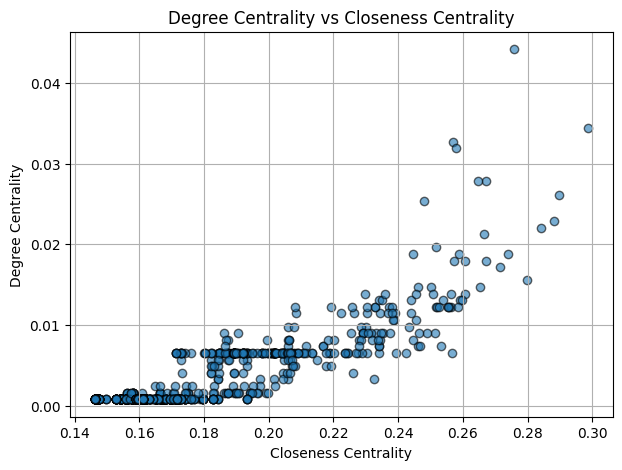

In [29]:
cc = compute_and_display_closeness_centrality(G, "Real Network")
plot_vs_degree(G, cc, "Degree Centrality vs Closeness Centrality", "Closeness Centrality", "Degree Centrality")

- Most nodes have low to moderate values on both centrality measures.

- There is a visible positive correlation: nodes with higher degree centrality tend to also have higher closeness centrality.

- A few outliers exhibit both high degree and high closeness, indicating well-connected nodes that are also close to others in the network.

__Interpretation__: This suggests that well-connected nodes tend to have shorter paths to others, enhancing their efficiency in spreading information across the network.

**Egienvector Centrality**


=== Real Network ===
Top 5 nodes by Eigenvector Centrality:
Node 7: 0.2951
Node 1: 0.2305
Node 6: 0.2063
Node 8: 0.2049
Node 42: 0.1996


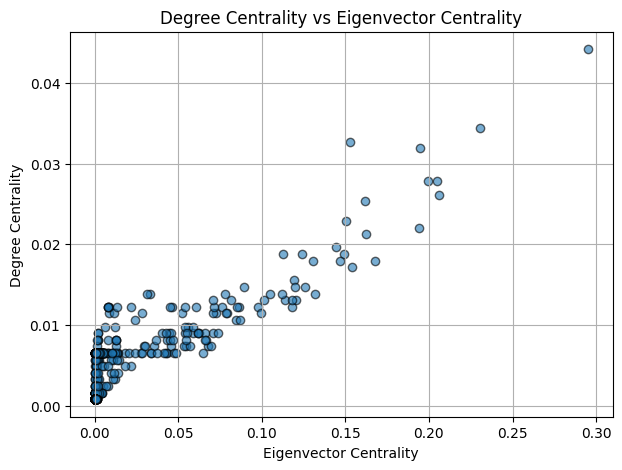

In [30]:
ec = compute_and_display_eigenvector_centrality(G, "Real Network")
if ec:
    plot_vs_degree(G, ec, "Degree Centrality vs Eigenvector Centrality", "Eigenvector Centrality", "Degree Centrality")

- Most nodes cluster near the origin, with low values for both centrality measures.

- A clear positive correlation is observed: nodes with higher degree centrality often have higher eigenvector centrality.

- A few prominent outliers dominate both measures, suggesting their influence and connectivity to other influential nodes.

__Interpretation__: This indicates that in this network, highly connected nodes tend to be connected to other well-connected nodes, reinforcing their central role in the network’s structure.

### Communities

Approach 1 (Hierarchical Agglomerative Clustering)

In [ ]:
def topological_overlap(G):
    nodes = list(G)
    neigh = {u: set(G[u]) for u in nodes}
    sim = {u: {} for u in nodes}
    for u in nodes:
        for v in nodes:
            if u == v:
                sim[u][v] = 1.0
            else:
                common = neigh[u] & neigh[v]
                a_uv   = 1 if G.has_edge(u, v) else 0
                # denominator: min(deg(u),deg(v)) + 1 - A_uv
                denom = min(len(neigh[u]), len(neigh[v])) + 1 - a_uv
                sim[u][v] = (len(common) + a_uv) / denom if denom > 0 else 0.0
    return sim

def agglomerative_communities(G, sim=None):
    if sim is None:
        sim = topological_overlap(G)
    nodes = list(G.nodes())
    n = len(nodes)

    # build the full dissimilarity matrix: diss(u,v) = 1 – sim(u,v)
    full_dist = np.zeros((n, n))
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            full_dist[i, j] = 1.0 - sim[u][v]

    # turn it into the condensed form that linkage expects
    dist_array = squareform(full_dist, checks=False)

    Z = linkage(dist_array, method='average')

    results = []
    for k in range(2, n):
        labels = fcluster(Z, k, criterion='maxclust')
        # build partition
        part = {}
        for idx, lbl in enumerate(labels):
            part.setdefault(lbl, set()).add(nodes[idx])
        communities = list(part.values())
        # evaluate modularity
        q = modularity(G, communities)
        results.append((communities, q))
    return results

def best_partition_by_modularity(results):
    return max(results, key=lambda x: x[1])

results = agglomerative_communities(G)
best_communities, best_q = best_partition_by_modularity(results)
print(f"Best modularity: {best_q:.4f}")

Best modularity: 0.9245


In [ ]:
for i, comm in enumerate(best_communities, start=1):
    print(f"Community {i}: {len(comm)} nodes")

Community 1: 280 nodes
Community 2: 67 nodes
Community 3: 30 nodes
Community 4: 16 nodes
Community 5: 124 nodes
Community 6: 180 nodes
Community 7: 137 nodes
Community 8: 46 nodes
Community 9: 208 nodes
Community 10: 110 nodes
Community 11: 191 nodes
Community 12: 149 nodes
Community 13: 124 nodes
Community 14: 164 nodes
Community 15: 142 nodes
Community 16: 116 nodes
Community 17: 97 nodes
Community 18: 237 nodes
Community 19: 48 nodes
Community 20: 34 nodes


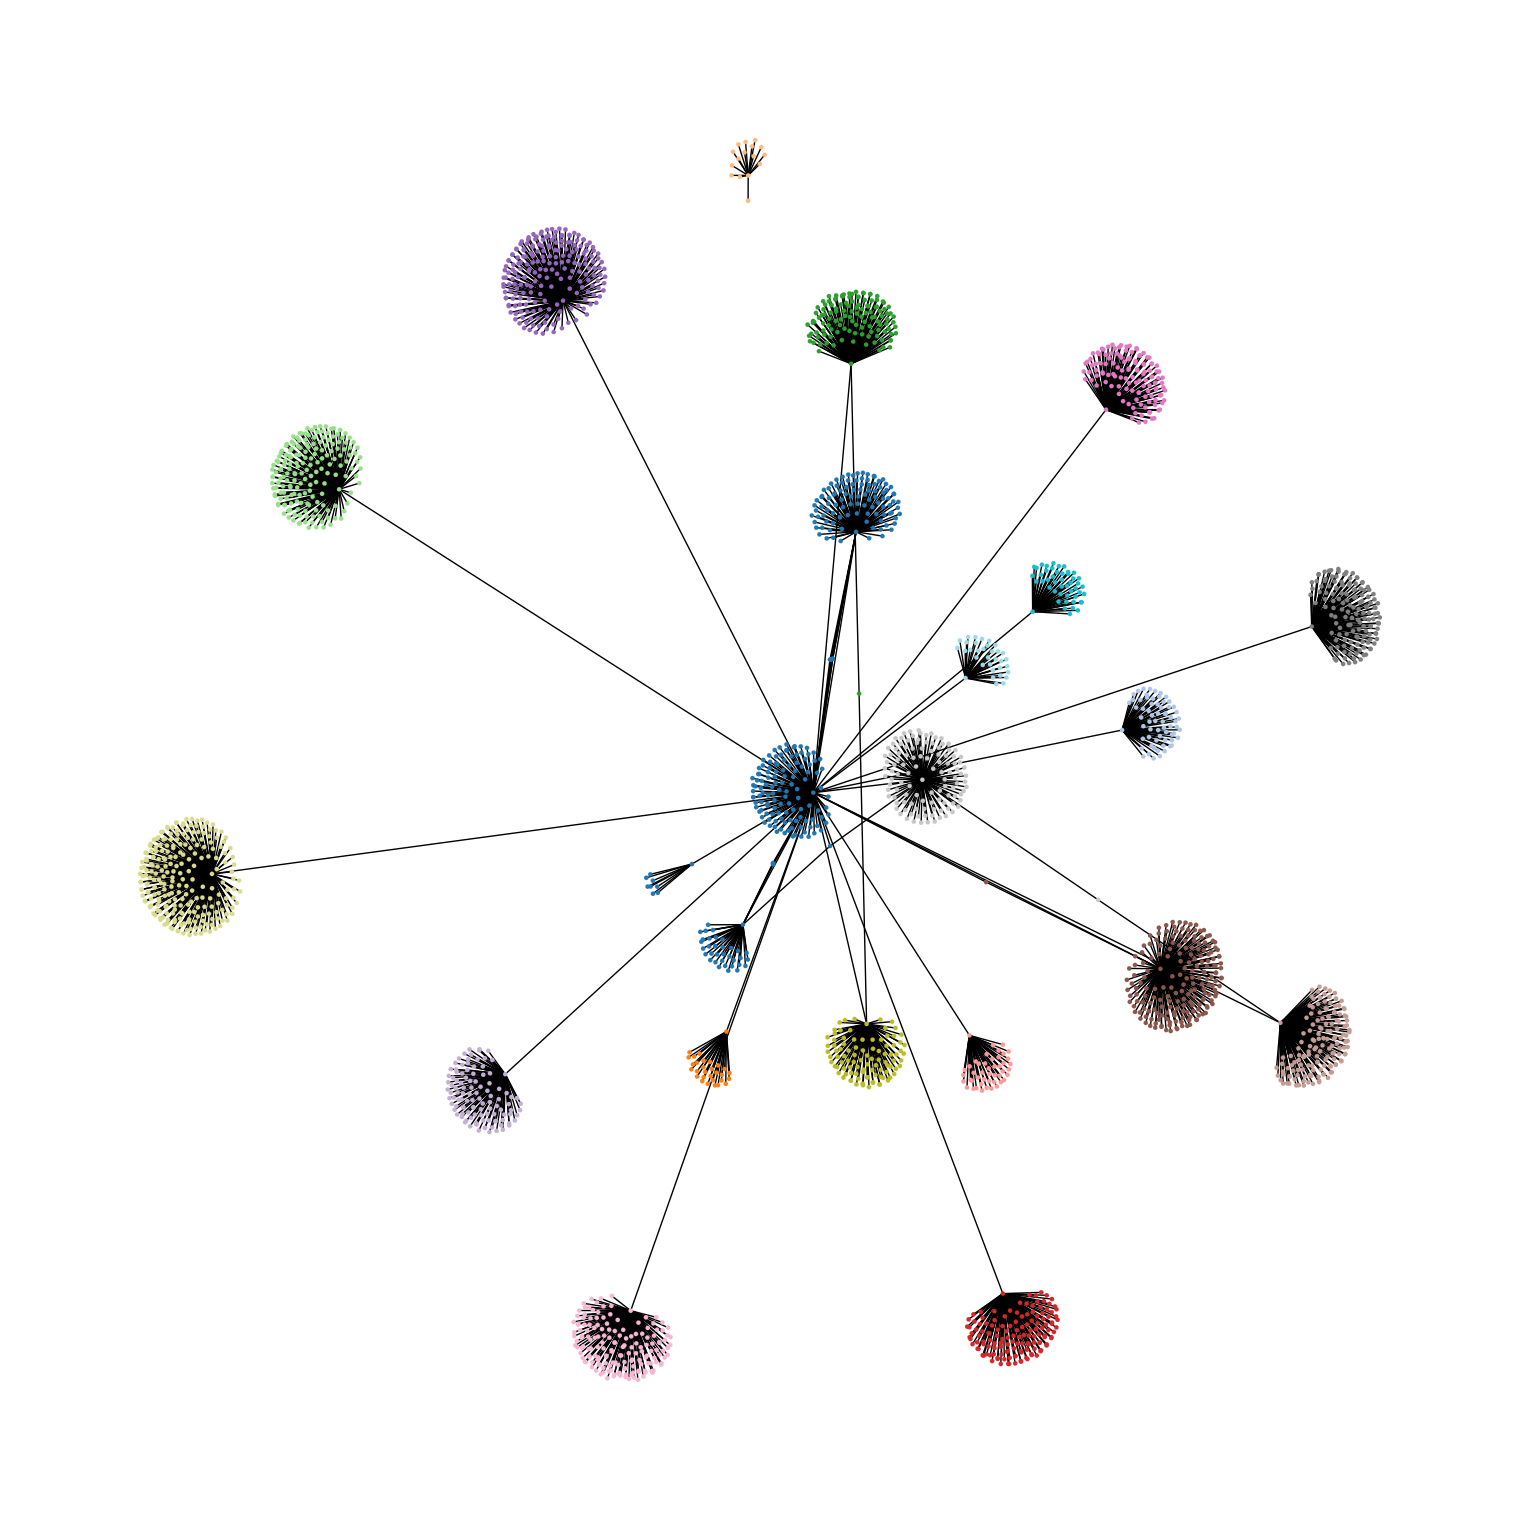

In [ ]:
node2com = {}
for com_id, comm in enumerate(best_communities):
    for node in comm:
        node2com[node] = com_id

colors = [node2com[n] for n in G.nodes()]

plt.figure(figsize=(15 ,15))
nx.draw_spring(G, node_color=colors, cmap=plt.cm.tab20, 
               node_size=10, linewidths=0.1)
plt.axis('off')
plt.show()

This is a **star** graph, meaning there are not many triangles formed within the community, only many leaves from one node.

Each colored blob is a tightly‐knit group of players who **mostly interact among themselves**: groups that may play together regularly.

Within each cluster you’ll notice **one or two nodes with many spikes** (high degree). Those are your **hub players**: popular group leaders or community managers who friend tons of people.
Their friends themselves aren’t generally friends with one another—so these aren’t tight “circles,” just one-to-many relationships. Friendships look **transactional** (one person friending many) **rather than communal** (between each other).

**Not many nodes with edges into two different color‐blobs**. That means people tend to friend one “hub” rather than multiple hubs.

The **most central community**, could be linked to the **person who manages the CS community**.

There is one small cluster detached form the main graph, probably when gathering the data, an id which was unlinked with the others was provided.

Approach 2 (Gephi Louvain)

![My diagram](community_detection.png)


## Gephi’s Louvain Partition  
*(modularity = 0.774, 34 communities at resolution 1.0) :contentReference[oaicite:0]{index=0}*

- **Dense, clique-like communities**: Each colored blob in the layout represents a set of players with lots of **internal triangles**—far more “friend-of-friend” links than in the star-graph version. Within each cluster, nodes are heavily interconnected.  
- **Hub nodes still exist, but in a communal context**: You’ll see a few nodes with very high degree inside each blob, yet their neighbors also tend to connect to one another. These are your **community facilitators**: popular players who bridge many within a tight-knit circle, rather than spokes on a star.  
- **Clear separation with few bridges**: There are scant edges between blobs, indicating that once you optimize modularity, each community becomes its own “island” of dense interactions. Players seldom straddle two different groups.  
- **Varied community sizes**: The size-distribution scatter shows one large community of ~115 nodes, several medium ones (60–90 nodes), and many small ones (under 10) :contentReference[oaicite:1]{index=1}. This reflects Louvain’s ability to find both broad and niche groups.  
- **Main component and peripheral clusters**: Unlike the agglomerative TO result, nearly all nodes are in the giant component, but peripheral, tightly-bound micro-communities still appear (the smallest blobs on the outskirts).

---

### Comparing the Two Approaches

| Aspect                  | TO-based Agglomerative                | Louvain (Multilevel Modularity)       |
|-------------------------|---------------------------------------|---------------------------------------|
| **Community shape**     | Star-like clusters; hubs with leaves  | Clique-like blobs; hubs within circles|
| **Similarity metric**   | Topological overlap (common neighbours)| Direct Δ modularity gain per move     |
| **Hierarchy**           | Full dendrogram; explore all cuts     | Greedy local moves + graph coarsening |
| **Scalability**         | O(n²) memory for full matrix          | Near-linear; no full matrix needed    |
| **Output flexibility**  | You choose *k* by modularity curve    | Stops when no Δ Q > 0                  |
| **Use-case “shine”**    | **Hub-and-spoke** roles; transactional links | **Natural social circles**; cohesive communities |

- **When TO shines**  
  If you care about identifying **hub-dominated**, one-to-many relationships or want a full cluster hierarchy to slice at any level, the topological-overlap approach is ideal.

- **When Louvain shines**  
  If you want a **fast**, high-modularity partition revealing **tight communities** and are less concerned with a full dendrogram, Louvain is the go-to—especially for large networks.


### Network Type Analysis